In [ ]:
#!pip install scikit-learn
#!pip install tensorflow

#tensorflow version= 2.17.0
# keras == 3.4.1
# sklearn-pandas == 2.2.0


In [ ]:
#!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 898.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successful

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from joblib import dump, load

import tensorflow
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Accuracy ,AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import CategoryEncoding
from tensorflow.keras.models import load_model
import tensorflow as tf

data_path="/content/drive/MyDrive/Colab Notebooks/El_Tah_Model/keypoint.csv"
model_path = "/content/drive/MyDrive/Colab Notebooks/El_Tah_Model/model.keras"
scaler_path="/content/drive/MyDrive/Colab Notebooks/El_Tah_Model/scaler.joblib"
######model kaç sınıf var buraya giriniz
modelS=3

In [4]:
def preprocess_data(data):
    x = pd.read_csv(data, header=None,usecols=list(range(1, (21 * 2) + 1)))
    y = pd.read_csv(data, header=None, usecols=[(0)])
    encoder=CategoryEncoding(num_tokens=modelS,output_mode='multi_hot')
    y=encoder(y).numpy()
    scaler=MinMaxScaler()
    X = scaler.fit_transform(x)
    dump(scaler, '/content/drive/MyDrive/Colab Notebooks/El_Tah_Model/scaler.joblib')
    return X,y

def prepare_datasets(X_train, X_val, y_train, y_val, batch_size=None):
    if batch_size is None:
        batch_size = len(X_train)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)
    return train_dataset, val_dataset

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

def get_best_epoch_details(history):
    val_losses = history.history['val_loss']
    min_val_loss_index = val_losses.index(min(val_losses))
    best_epoch = min_val_loss_index + 1

    epoch_details = {}
    for key in history.history.keys():
        epoch_details[key] = history.history[key][min_val_loss_index]

    epoch_details['best_epoch'] = best_epoch
    print(f"Best epoch details: {epoch_details}")
def get_best_epoch_details(history):
    val_losses = history.history['val_loss']
    min_val_loss_index = val_losses.index(min(val_losses))
    best_epoch = min_val_loss_index + 1

    epoch_details = {}
    for key in history.history.keys():
        epoch_details[key] = history.history[key][min_val_loss_index]

    epoch_details['best_epoch'] = best_epoch
    print(f"Best epoch details: {epoch_details}")

In [5]:
X,y= preprocess_data(data_path)
print(X.shape)
print(y.shape)

(512, 42)
(512, 3)


In [6]:
x_train,x_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [7]:
train_ds,val_ds=prepare_datasets(x_train,x_val,y_train,y_val)

In [ ]:
#Tensorflow data setini cıktısını almak icin yazılmış bir koddur
#for features,labels in val_ds.take(1):
  #print('featers:',features.numpy(),'label:',labels.numpy())

In [11]:
model = Sequential()
model.add(Input(shape=(21 * 2,)))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(modelS, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy','AUC'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 32)                  │           1,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,147 (8.39 KB)

 Trainable params: 2,051 (8.01 KB)

 Non-trainable params: 96 (384.00 B)

In [9]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)
#model.keras adı ile model kayıt edilir
model_chek_point=ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True)

In [10]:
start_time=datetime.datetime.now()
history = model.fit(train_ds,validation_data=val_ds,epochs=500,callbacks=[early_stopping,model_chek_point],batch_size=32)
end_time=datetime.datetime.now()
print(str(end_time-start_time))


Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - AUC: 0.4547 - accuracy: 0.3032 - loss: 1.1228 - val_AUC: 0.3323 - val_accuracy: 0.3495 - val_loss: 0.8295
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.4968 - accuracy: 0.3276 - loss: 1.0037 - val_AUC: 0.3545 - val_accuracy: 0.3592 - val_loss: 0.8265
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - AUC: 0.5319 - accuracy: 0.3252 - loss: 0.8766 - val_AUC: 0.3792 - val_accuracy: 0.3786 - val_loss: 0.8229
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - AUC: 0.5505 - accuracy: 0.3545 - loss: 0.9013 - val_AUC: 0.3963 - val_accuracy: 0.3786 - val_loss: 0.8205
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - AUC: 0.5843 - accuracy: 0.4181 - loss: 0.8354 - val_AUC: 0.4205 - val_accuracy: 0.3883 - val_loss: 0.8170
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - AUC: 0.5845 - accuracy: 0.3594 - loss: 0.8099 - val_AUC: 0.4603 - val_accuracy: 0.4660 - val_loss: 0.8115
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step -

In [12]:
#en iyi epoch detayları
get_best_epoch_details(history)
#Best epoch details: {'AUC': 0.9622550010681152, 'accuracy': 0.6479217410087585, 'loss': 0.1353987604379654, 'val_AUC': 0.9977797269821167, 'val_accuracy': 0.6504854559898376, 'val_loss': 0.34887072443962097, 'best_epoch': 225}
#bu modelin değerleri


Best epoch details: {'AUC': 0.9236127138137817, 'accuracy': 0.7017114758491516, 'loss': 0.19999834895133972, 'val_AUC': 0.9644134640693665, 'val_accuracy': 0.6310679316520691, 'val_loss': 0.3795751631259918, 'best_epoch': 217}


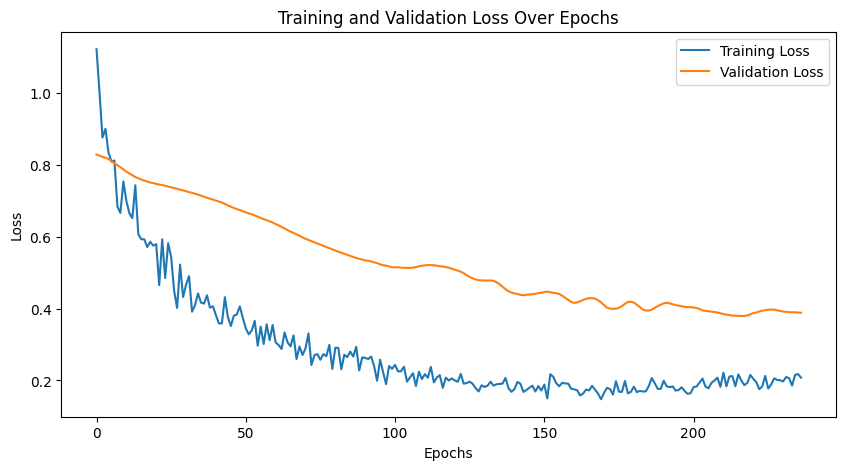

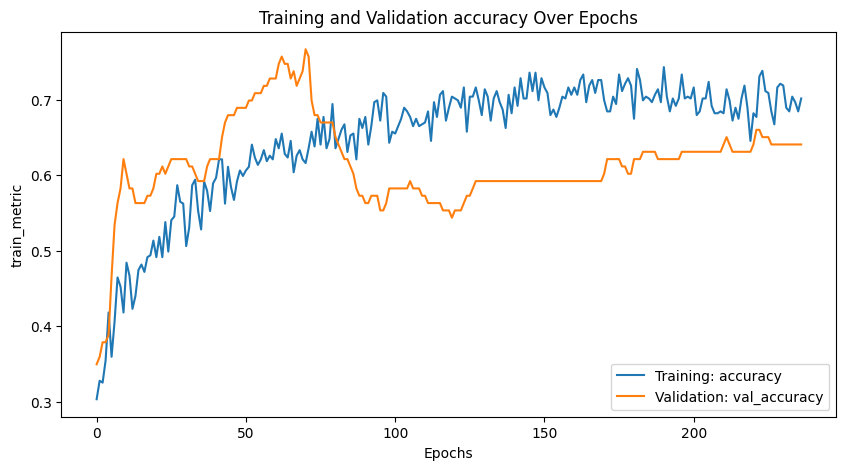

In [13]:
plot_training_history(history)

In [14]:
#model ve scaler indirmek
from google.colab import files
files.download(model_path)
files.download(scaler_path)
#yuklenen dosyaları El_algılama/keypoint_classifier dosyasının icine aktarın

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
  #modele kayıt ettiğiniz verilerden tahmin yaptırma (başındaki ilk sayıytı silmezseniz hata alırsınız)
  model=tensorflow.keras.models.load_model(model_path)

  import pandas as pd
  data="0,0,-46,-26,-84,-60,-113,-84,-111,-108,-37,-123,-60,-154,-83,-140,-99,-119,-14,-133,-25,-181,-44,-206,-61,-225,10,-129,8,-180,-3,-207,-14,-228,30,-113,44,-150,48,-175,51,-198"
  data = pd.DataFrame(data.split(',')).T
  scaler=load(scaler_path)

  data=scaler.transform(data)
  test_dataset = tf.data.Dataset.from_tensor_slices(data)
  test_dataset = test_dataset.batch(len(data))

In [16]:
pred=model.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [17]:
pred

array([[0.33217645, 0.5079714 , 0.15985212]], dtype=float32)